<a href="https://colab.research.google.com/github/soyoonjeong/MachineLearning/blob/main/3_%ED%8F%89%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

성능 평가 지표
- 회귀 : 실제값과 예측값의 오차 평균값 기반
- 분류 : 정확도, 오차행렬, 정밀도, 재현율, ...<BR>
이번 챕터에서는 분류의 성능 평가 지표에 대해 알아봄 !

# 정확도
: 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단<BR>
PROBLEM : 이진 분류에서 데이터 구성에 따라 ML 모델 성능을 왜곡할 수 있음 


### 예시 1 : 타이타닉 데이터에서 여자는 생존, 남자는 사망으로 예측

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
  def fit(self, X, y = None):
    pass
  def predict(self, X):
    pred = np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
      if X['Sex'].iloc[i]==1:
        pred[i] = 0
      else:
        pred[i] = 1
    return pred

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

titanic_df = pd.read_csv("/content/drive/MyDrive/datasets/타이타닉/train.csv")
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 49)

myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)
mypredictions = myclf.predict(X_test)
print('Dummy Classfier의 정확도 : {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classfier의 정확도 : 0.7765


성별에 따라 단순하게 예측한 결과도 0.7765라는 높은 정확도를 보이고 있음 -> 문제

### 예시 2 MNIST 데이터 : 레이블 분포가 불균형한 경우 
- 데이터 : MNIST 데이터셋
- 분류 : 7과 7이 아닌 것 
- 데이터 분포 : 7이 아닌 것이 90%
- 예측 : 다 7이 아니라고 예측

In [5]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class myFakeClassifier(BaseEstimator):
  def fit(self, X, y):
    pass
  def predict(self, X):
    return np.zeros((len(X),1), dtype = bool)

digits = load_digits()
print('### digits.data.shape :', digits.data.shape)
print('### digits.target.shape :', digits.target.shape)
y = (digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state = 49)

### digits.data.shape : (1797, 64)
### digits.target.shape : (1797,)


In [6]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 : ', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도 : ', pd.Series(y_test).value_counts())

# DummyClassifier로 학습/예측/정확도 평가
fakeclf = myFakeClassifier()
fakeclf.fit(X_train, y_train)
pred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))

레이블 테스트 세트 크기 :  (450,)
테스트 세트 레이블 0과 1의 분포도 :  0    410
1     40
dtype: int64
모든 예측을 0으로 하여도 정확도 : 0.9111


# 오차 행렬
Classifier 성능의 여러 면모를 판단할 수 있는 기반 정보 제공 

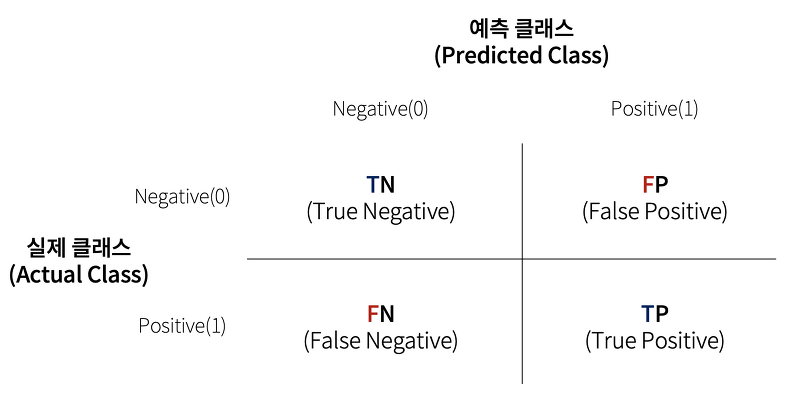

In [7]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred) # 앞 MNIST 데이터 예시

array([[410,   0],
       [ 40,   0]])

# 정밀도와 재현율

Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표 
- 정밀도(precision) : 예측을 positive로 한 것들 중 예측과 실제값이 positive로 일치한 데이터의 비율 (예측 중 실제)<br>
TP / (TP+FP)<BR>
- 재현율(recall) : 실제값이 positive인 대상 중에 예측과 실제 값이 positive로 일치한 데이터의 비율(실제 중 예측)<br>
TP / (TP+FN)<BR>

- 정밀도가 더 중요한 지표인 경우 : positive를 신중하게 예측해야 하는 경우 ex) 스팸 메일 분류 <br>
실제 negative인 데이터를 positive로 예측하면 큰일
- 재현율이 더 중요한 지표인 경우 : positive를 놓치면 안되는 경우 ex) 암 판단 모델, 금융 사기 적발 모델<br>
실제 positive인 데이터를 negative로 예측하면 큰일

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print("오차 행렬 :")
  print(confusion)
  print("정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}".format(accuracy,precision,recall))

In [9]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv("/content/drive/MyDrive/datasets/타이타닉/train.csv")
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 49)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬 :
[[97 17]
 [14 51]]
정확도 : 0.8268, 정밀도 : 0.7500, 재현율 : 0.7846


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## 정밀도/재현율 트레이드오프

분류의 결정 임곗값을 조정해 정밀도 또는 재현율의 수치를 높힐 수 있음 

#### predict_proba() 메소드 확인

In [10]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)

print('pred_proba() 결과 shape : ', pred_proba.shape)
# 예측 확률 array와 예측 결과값 array를 concatenate 하여 예측 확률과 결과값을 한눈에
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis = 1) # pred : 1차원->2차원
print("두개의 class 중에서 더 큰 확률을 클래스 값으로 예측")
print(pred_proba_result[:10])


pred_proba() 결과 shape :  (179, 2)
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측
[[0.87229936 0.12770064 0.        ]
 [0.85554841 0.14445159 0.        ]
 [0.8761385  0.1238615  0.        ]
 [0.78361667 0.21638333 0.        ]
 [0.19121293 0.80878707 1.        ]
 [0.87233662 0.12766338 0.        ]
 [0.92877655 0.07122345 0.        ]
 [0.35652991 0.64347009 1.        ]
 [0.47961    0.52039    1.        ]
 [0.7711604  0.2288396  0.        ]]


#### Binarizer 활용

In [11]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
     [2,0,0],
     [0,1.1,1.2]]
binarizer = Binarizer(threshold = 1.1) # threshold 이하 0, 초과 1
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


#### 여러 개의 분류 결정 임곗값을 변경하면서 Binarizer를 이용하여 예측값 변환

In [12]:
threshold = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold = custom_threshold)
    custom_predict = binarizer.fit_transform(pred_proba_c1)
    print("임곗값 : ", custom_threshold)
    get_clf_eval(y_test, custom_predict)
    print("----------------------------------------------")

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), threshold) # reshape(-1,1)로 2차원으로 변환

임곗값 :  0.4
오차 행렬 :
[[91 23]
 [14 51]]
정확도 : 0.7933, 정밀도 : 0.6892, 재현율 : 0.7846
----------------------------------------------
임곗값 :  0.45
오차 행렬 :
[[95 19]
 [14 51]]
정확도 : 0.8156, 정밀도 : 0.7286, 재현율 : 0.7846
----------------------------------------------
임곗값 :  0.5
오차 행렬 :
[[97 17]
 [14 51]]
정확도 : 0.8268, 정밀도 : 0.7500, 재현율 : 0.7846
----------------------------------------------
임곗값 :  0.55
오차 행렬 :
[[99 15]
 [16 49]]
정확도 : 0.8268, 정밀도 : 0.7656, 재현율 : 0.7538
----------------------------------------------
임곗값 :  0.6
오차 행렬 :
[[105   9]
 [ 19  46]]
정확도 : 0.8436, 정밀도 : 0.8364, 재현율 : 0.7077
----------------------------------------------


임곗값이 올라갈수록 정밀도 증가, 재현율 감소

#### precision_recall_curve()를 이용하여 임곗값에 따른 정밀도-재현율 값 추출
정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태의 그래프로 시각화 

In [13]:
from sklearn.metrics import precision_recall_curve

# 레이블이 1일 때의 확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 셋과 레이블 값이 1일 떄의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print("반환된 분류 결정 임곗값 배열의 shape : ", thresholds.shape)
print("반환된 precisions 배열의 shape : ", precisions.shape)
print("반환된 recalls 임곗값 배열의 shape : ", recalls.shape)

# 반환된 임곗값 배열 로우가 147건이므로 샘플로 10건만 추출하되 15 step으로 
thr_idx = np.arange(0, thresholds.shape[0], 15)
print("샘플 추출을 위한 임곗값 배열의 index 10개 : ", thr_idx)
print("샘플용 10개의 임곗값 : ", np.round(thresholds[thr_idx],3))
print("샘플 임계값별 정밀도 : ", np.round(precisions[thr_idx],3))
print("샘플 임계값별 재현율 : ", np.round(recalls[thr_idx],3))

반환된 분류 결정 임곗값 배열의 shape :  (144,)
반환된 precisions 배열의 shape :  (145,)
반환된 recalls 임곗값 배열의 shape :  (145,)
샘플 추출을 위한 임곗값 배열의 index 10개 :  [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값 :  [0.101 0.128 0.157 0.215 0.313 0.499 0.612 0.691 0.846 0.935]
샘플 임계값별 정밀도 :  [0.43  0.477 0.53  0.586 0.655 0.739 0.833 0.923 1.    1.   ]
샘플 임계값별 재현율 :  [1.    0.954 0.938 0.892 0.846 0.785 0.692 0.554 0.369 0.138]


임계값이 증가할수록 정밀도 증가, 재현율 감소

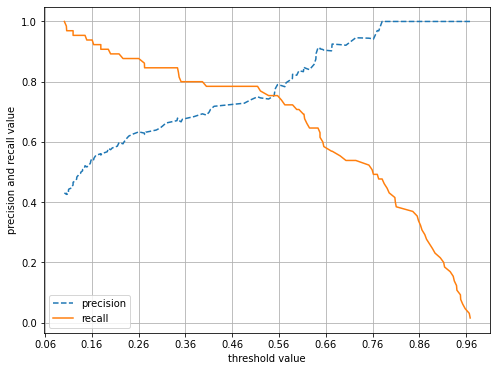

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  plt.figure(figsize = (8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')

  start,end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))

  plt.xlabel('threshold value')
  plt.ylabel('precision and recall value')
  plt.legend()
  plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, pred_proba_class1)

## 정밀도와 재현율의 맹점

임계값은 업무 환경에 맞게 정밀도와 재현율을 상호 보완할 수 있는 수준에서 적용되어야 함
- 정밀도 100% 되는 법 : threshold 극단적으로 높힘<br>
확실한 기준이 되는 경우만 positive로 예측
- 재현율 100% 되는 법 : threshold 극단적으로 낮춤<br>
모든 환자를 positive로 예측<BR>
PROBLEM : 정밀도 또는 재현율이 하나만 높고 하나만 낮은 분류는 좋은 분류가 아님

# F1 스코어

SOLUTION : F1 스코어 <BR>
정밀도와 재현율 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐

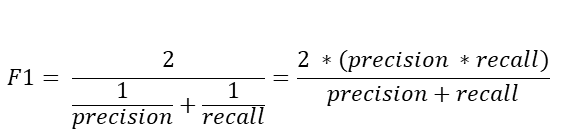

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  print("오차 행렬 :")
  print(confusion)
  print("정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 :{3:.4f}".format(accuracy,precision,recall, f1))
threshold = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), threshold) # reshape(-1,1)로 2차원으로 변환

임곗값 :  0.4
오차 행렬 :
[[91 23]
 [14 51]]
정확도 : 0.7933, 정밀도 : 0.6892, 재현율 : 0.7846, F1 :0.7338
----------------------------------------------
임곗값 :  0.45
오차 행렬 :
[[95 19]
 [14 51]]
정확도 : 0.8156, 정밀도 : 0.7286, 재현율 : 0.7846, F1 :0.7556
----------------------------------------------
임곗값 :  0.5
오차 행렬 :
[[97 17]
 [14 51]]
정확도 : 0.8268, 정밀도 : 0.7500, 재현율 : 0.7846, F1 :0.7669
----------------------------------------------
임곗값 :  0.55
오차 행렬 :
[[99 15]
 [16 49]]
정확도 : 0.8268, 정밀도 : 0.7656, 재현율 : 0.7538, F1 :0.7597
----------------------------------------------
임곗값 :  0.6
오차 행렬 :
[[105   9]
 [ 19  46]]
정확도 : 0.8436, 정밀도 : 0.8364, 재현율 : 0.7077, F1 :0.7667
----------------------------------------------


# ROC 곡선과 AUC

- ROC 곡선 : FPR이 변할 때 TPR이 어떻게 변하는지를 나타내는 곡선
  - FPR : FP/(FP+TN)
  - TPR : TP/(TP+FN) = 재현율
  - FPR = 0 : 임곗값 = 1 (positive로 예측하지 못하도록)
  - FPR = 1: 임곗값 = 0 (negative로 예측하지 못하도록)

In [16]:
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 step으로 추출
# thresholds[0]은 max(예측확률)+1로 임의 설정됨, 이를 제외하기 위해 1부터 시작
thr_idx = np.arange(1, thresholds.shape[0], 5)
print("샘플 추출을 위한 임곗값 배열의 index 10개 : ", thr_idx)
print("샘플용 10개의 임곗값 : ", np.round(thresholds[thr_idx],3))
print("샘플 임계값별 FPR : ", np.round(fprs[thr_idx],3))
print("샘플 임계값별 TPR : ", np.round(tprs[thr_idx],3))

샘플 추출을 위한 임곗값 배열의 index 10개 :  [ 1  6 11 16 21 26 31 36 41 46]
샘플용 10개의 임곗값 :  [0.969 0.724 0.625 0.589 0.405 0.26  0.193 0.149 0.116 0.106]
샘플 임계값별 FPR :  [0.    0.018 0.07  0.088 0.202 0.289 0.395 0.5   0.675 0.754]
샘플 임계값별 TPR :  [0.015 0.538 0.646 0.723 0.785 0.877 0.908 0.938 0.969 0.985]


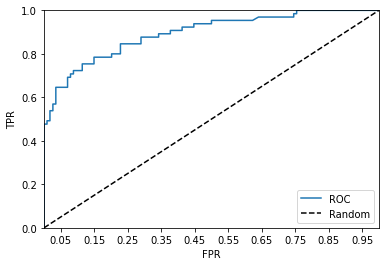

In [17]:
def roc_curve_plot(y_test, pred_proba_c1):
  fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)

  plt.plot(fprs, tprs, label = 'ROC')
  plt.plot([0,1],[0,1], 'k--',label = 'Random')

  start,end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1),2))
  plt.xlim(0,1)
  plt.ylim(0,1)
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend()
  plt.show()

roc_curve_plot(y_test, pred_proba_class1)

- AUC : ROC 곡선의 아래 면적 넓이<BR>
일반적으로 1에 가까울수록 좋은 수치


In [18]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값 :', roc_score)

ROC AUC 값 : 0.8943319838056681


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba= None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  auc = roc_auc_score(y_test, pred_proba)
  print("오차 행렬 :")
  print(confusion)
  print("정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 :{3:.4f}, AUC : {4:.4f}".format(accuracy,precision,recall, f1, auc))
  print("---------------------------------------------------------------------------------")

# 피마 인디언 당뇨병 예측

## 데이터 로드 및 확인, 전처리

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv("/content/drive/MyDrive/datasets/diabetes.csv")
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head()

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


레이블 데이터 불균형 있음

In [21]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [22]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [23]:
zero_features = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

total_count = diabetes_data['Glucose'].count()

for feature in zero_features:
  zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
  print("{0} 0 건수는 {1}, 퍼센트는 {2:.2f}%".format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65%
BloodPressure 0 건수는 35, 퍼센트는 4.56%
SkinThickness 0 건수는 227, 퍼센트는 29.56%
Insulin 0 건수는 374, 퍼센트는 48.70%
BMI 0 건수는 11, 퍼센트는 1.43%


Glucose, BloodPressure, SkinThickness, Insulin, BMI의 min이 0인 것이 이상해서 평균으로 대체 

In [24]:
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, diabetes_data[zero_features].mean())

## 로지스틱회귀 모델 생성, 평가

In [27]:
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

# StandardScaler 클래스를 이용하여 피처 데이터 세트에 일괄적으로 스케일링 적용
# 표준화 : 데이터 피처 각각의 평균이 0이고 분산이 1인 가우시안 정규 분포를 가진 값으로 변환 
# 표준화는 서포트벡터머신, 선형회귀, 로지스틱회귀에서 성능향상에 중요한 요소 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 49)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬 :
[[83  8]
 [27 36]]
정확도 : 0.7727, 정밀도 : 0.8182, 재현율 : 0.5714, F1 :0.6729, AUC : 0.8577


## 재현율을 위해 임계값 조정

In [28]:
from sklearn.preprocessing import Binarizer

def get_eval_by_thresholds(y_test, pred_proba_c1, thresholds):
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold = custom_threshold)
    custom_pred = binarizer.fit_transform(pred_proba_c1)
    print("임곗값 :", custom_threshold)
    get_clf_eval(y_test, custom_pred, pred_proba_c1)

In [32]:
thresholds = [0.3, 0.33, 0.36,0.39,0.42,0.45,0.48,0.50]
pred_proba = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)
get_eval_by_thresholds(y_test, pred_proba, thresholds)

임곗값 : 0.3
오차 행렬 :
[[68 23]
 [16 47]]
정확도 : 0.7468, 정밀도 : 0.6714, 재현율 : 0.7460, F1 :0.7068, AUC : 0.8577
---------------------------------------------------------------------------------
임곗값 : 0.33
오차 행렬 :
[[72 19]
 [17 46]]
정확도 : 0.7662, 정밀도 : 0.7077, 재현율 : 0.7302, F1 :0.7188, AUC : 0.8577
---------------------------------------------------------------------------------
임곗값 : 0.36
오차 행렬 :
[[76 15]
 [21 42]]
정확도 : 0.7662, 정밀도 : 0.7368, 재현율 : 0.6667, F1 :0.7000, AUC : 0.8577
---------------------------------------------------------------------------------
임곗값 : 0.39
오차 행렬 :
[[79 12]
 [23 40]]
정확도 : 0.7727, 정밀도 : 0.7692, 재현율 : 0.6349, F1 :0.6957, AUC : 0.8577
---------------------------------------------------------------------------------
임곗값 : 0.42
오차 행렬 :
[[80 11]
 [23 40]]
정확도 : 0.7792, 정밀도 : 0.7843, 재현율 : 0.6349, F1 :0.7018, AUC : 0.8577
---------------------------------------------------------------------------------
임곗값 : 0.45
오차 행렬 :
[[82  9]
 [24 39]]
정확도 : 0.7857, 정밀도 : 0.8125, 

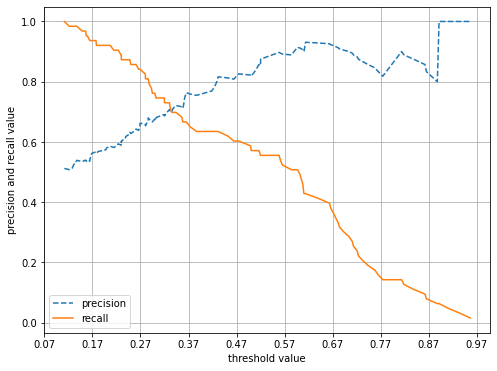

In [34]:
def precision_recall_curve_plot(y_test=None, pred_proba_c1 = None):
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
  
  plt.figure(figsize = (8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')

  start,end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1),2))

  plt.xlabel('threshold value')
  plt.ylabel('precision and recall value')
  plt.legend()
  plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, pred_proba)

In [35]:
binarizer = Binarizer(threshold = 0.3)
pred_thr_03 = binarizer.fit_transform(pred_proba)
get_clf_eval(y_test, pred_thr_03, pred_proba)

오차 행렬 :
[[68 23]
 [16 47]]
정확도 : 0.7468, 정밀도 : 0.6714, 재현율 : 0.7460, F1 :0.7068, AUC : 0.8577
---------------------------------------------------------------------------------
